In [2]:
# Get imports
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [3]:
# I do not know where this came from
# Preprocess step because the imagenet training images used for the Xception was of size 224x224
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [4]:
# Getting the path to the current working directory
from pathlib import Path
import os

path = Path(os.getcwd())
path

PosixPath('/Users/ryuparish/Code/butterfly_train')

In [5]:
# Getting all the paths for each image of clothing in the dataset
# os.walk returns the current walking directory, the subdirectories within it, and then finally the files within it.
def printDirs(path): 
    for name, subdirs, files in os.walk(path):

        # The name variable keeps gettin longer as you get further away from the path folder
        # aclImdb, aclImdb/test, aclImdb/test/neg ... 
        indent = len(Path(name).parts) - len(path.parts)

        # os.sep adds a "/" if necessary 
        print("    " * indent + Path(name).parts[-1] + os.sep)
        for index, filename in enumerate(sorted(files)):

            # If we have printed three items already, just go ahead and print and ellipsis and move on
            if index == 3:
                print("    " * (indent + 1) + "...")
                break
            print("    " * (indent + 1) + filename)

printDirs(path)

butterfly_train/
    ColorClothingModel.h5
    EfficientNetModelB1.h5
    Transfer Learning Color Clothing Success.ipynb
    ...
    .ipynb_checkpoints/
        Transfer Learning Color Clothing Success-checkpoint.ipynb
    .git/
        COMMIT_EDITMSG
        HEAD
        config
        ...
        objects/
            pack/
                pack-5d4cd1e2674ae9f3cd3280958d7fa076977cbe43.idx
                pack-5d4cd1e2674ae9f3cd3280958d7fa076977cbe43.pack
            45/
                41ff3563d6e7e36c05aa836e8cad357a96678d
            7b/
                23ce75557b4ce5fca40ae9235aad5692f20cf1
            8f/
                a8c24ea2c6b6a06a6a030100858ff5e2226859
            4c/
                ff697f571153f977b12333feebbf4e1a609e7d
            44/
                448f3112d1dfaf1badb13abda4468a9f50bae7
            info/
            62/
                a3eab8254daed1fd890dc13b7a3cad2a2d0ba9
            bf/
                18cca4d384ec31e655c9eb80cf0f4df48dead8
            dc/
         

In [5]:
# Function to get all the image paths and glob them into one large list and then convert the PosixPath's into
# strings
def image_paths(dirpath):
    # PosixPath.glob will get all the path names of a specific pattern and return all of them in a list
    return [str(path) for path in dirpath.glob("*.jpg")]

# Sort of hacky.
# Getting the paths to all the images
clothing_dataset = image_paths(path/"data")

In [7]:
# Making an encoder to store all the encoded versions of the clothing classes
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# All classes
clothing_table = [
    "black_dress",
    "black_pants",
    "black_shirt",
    "black_shoes",
    "black_shorts",
    "black_suit",
    "blue_dress",
    "blue_pants",
    "blue_shirt",
    "blue_shoes",
    "blue_shorts",
    "brown_hoodie",
    "brown_pants",
    "brown_shoes",
    "green_pants",
    "green_shirt",
    "green_shoes",
    "green_shorts",
    "green_suit",
    "pink_hoodie",
    "pink_pants",
    "pink_skirt",
    "red_dress",
    "red_hoodie",
    "red_pants",
    "red_shirt",
    "red_shoes",
    "silver_shoes",
    "silver_skirt",
    "white_dress",
    "white_pants",
    "white_shoes",
    "white_shorts",
    "white_suit",
    "yellow_dress",
    "yellow_shorts",
    "yellow_skirt"
]

encoder.fit(clothing_table)
print(encoder.classes_)
print("This many classes:", len(encoder.classes_))

['black_dress' 'black_pants' 'black_shirt' 'black_shoes' 'black_shorts'
 'black_suit' 'blue_dress' 'blue_pants' 'blue_shirt' 'blue_shoes'
 'blue_shorts' 'brown_hoodie' 'brown_pants' 'brown_shoes' 'green_pants'
 'green_shirt' 'green_shoes' 'green_shorts' 'green_suit' 'pink_hoodie'
 'pink_pants' 'pink_skirt' 'red_dress' 'red_hoodie' 'red_pants'
 'red_shirt' 'red_shoes' 'silver_shoes' 'silver_skirt' 'white_dress'
 'white_pants' 'white_shoes' 'white_shorts' 'white_suit' 'yellow_dress'
 'yellow_shorts' 'yellow_skirt']
This many classes: 37


In [8]:
# For labelling each image
def label_image(filename):
    # Getting the last file instead of the entire file path
    depth_of_file = filename.count("/")
    split_filepath = filename.split("/", depth_of_file)
    real_filename = split_filepath[-1]
    
    label = real_filename[0:real_filename.find("_", 7)]
    # Returning the image and the encoded label
    return filename, encoder.transform([label])[0]

# For showing the image
def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

In [9]:
# Labelling the images
clothing_dataset = map(label_image, clothing_dataset)
clothing_dataset = list(clothing_dataset)

In [10]:
# Shuffling the dataset and splitting it up into train, validation, and test sets
np.random.shuffle(clothing_dataset)
clothing_dataset = np.asarray(clothing_dataset)
train = clothing_dataset[:14170]
valid = clothing_dataset[14170:15170]
test = clothing_dataset[15170:16170]

In [11]:
# Splitting into instances and labels
x_train = train[:,0]
y_train = train[:,1].astype(np.uint8)
x_valid = valid[:,0]
y_valid = valid[:,1].astype(np.uint8)
x_test = test[:,0]
y_test = test[:,1].astype(np.uint8)

In [12]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# This works too
def parse_image2(filepath):
    image = load_img(filepath)
    image = image.resize((224,224))
    image = img_to_array(image)
    return image

In [13]:
# Image parsing and then attaching a label based on the name of the file
# Original
from PIL import Image
def parse_image(filepath):
    # Getting the image from the filepath
    image = Image.open(filepath)
    image = image.resize((224, 224))
    image = np.asarray(image)
    # Returning the image and the encoded label
    return image

In [14]:
# Converting the filepaths into images and then into numpy arrays
x_train = map(parse_image, x_train)
x_train = np.asarray(list(x_train))
x_train = tf.keras.applications.mobilenet_v2.preprocess_input(x_train)

KeyboardInterrupt: 

In [16]:
# Saving the dataset as a h5 file 
#data_file = h5py.File('x_train_data.h5', 'w')
#data_file.create_dataset('x_train_data', data=x_train)
#data_file.close()

In [14]:
# Restoring the dataset as a numpy array
data_file = h5py.File('x_train_data.h5', 'r')
x_train = data_file["x_train_data"][...]
data_file.close()
#x_train = tf.keras.applications.mobilenet_v2.preprocess_input(x_train)

In [31]:
x_valid = map(parse_image, x_valid)
x_valid = np.asarray(list(x_valid))
x_valid = tf.keras.applications.mobilenet_v2.preprocess_input(x_valid)

In [18]:
#data_file = h5py.File('x_valid_data.h5', 'w')
#data_file.create_dataset('x_valid_data', data=x_valid)
#data_file.close()

In [15]:
# Restoring the dataset as a numpy array
data_file = h5py.File('x_valid_data.h5', 'r')
x_valid = data_file["x_valid_data"][...]
data_file.close()
#x_valid = tf.keras.applications.mobilenet_v2.preprocess_input(x_valid)

In [33]:
x_test = map(parse_image, x_test)
x_test = np.asarray(list(x_test))
x_test = tf.keras.applications.mobilenet_v2.preprocess_input(x_test)

In [20]:
#data_file = h5py.File('x_test_data.h5', 'w')
#data_file.create_dataset('x_test_data', data=x_test)
#data_file.close()

In [16]:
# Restoring the dataset as a numpy array
data_file = h5py.File('x_test_data.h5', 'r')
x_test = data_file["x_test_data"][...]
data_file.close()
#x_test = tf.keras.applications.mobilenet_v2.preprocess_input(x_test)

In [34]:
# Sanity Check
print(x_train.shape)
x_train[0,0]

(14170, 224, 224, 3)


array([[ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.   

In [ ]:
# Option 1
# Converting the instances to tf datasets\
# This will crash the kernel after the previous steps
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
testing_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
# Turning the filepaths of images to their rightful images
training_dataset = training_dataset.shuffle(2000).batch(32).prefetch(1)
valid_dataset = valid_dataset.shuffle(2000).batch(32).prefetch(1)
testing_dataset = testing_dataset.batch(32)

In [ ]:
# Preprocessing the images so that they normalized before being trained on
#from tensorflow.keras.layers.experimental import preprocessing
#layer = preprocessing.Normalization()
#layer.adapt(x_train[500])

In [ ]:
# Mapping datasets to the normalizing function THIS WORKS!!!!!!
# Reading the documentation, the EfficientNet model expects 0-255... I am a failure
#training_dataset.map(lambda x, y: (layer(x), y))
#valid_dataset.map(lambda x, y: (layer(x), y))
#testing_dataset.map(lambda x, y: (layer(x), y))

In [ ]:
# Try to add some image augmentation
# Option 2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    brightness_range=(0.45, 1.0))

In [ ]:
datagen.fit([x_train[800]])

In [24]:
# Sanity Check because aurelien is a dolt
for something in training_dataset:
    print(something[0])
    break

tf.Tensor(
[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[227 227 227]
   [227 227 227]
   [227 227 227]
   ...
   [237 237 237]
   [237 237 237]
   [237 237 237]]

  [[227 227 227]
   [227 227 227]
   [227 227 227]
   ...
   [237 237 237]
   [237 237 237]
   [237 237 237]]

  [[227 227 227]
   [227 227 227]
   [227 227 227]
   ...
   [237 237 237]
   [237 237 237]


In [25]:
# Building the top of the model
n_classes = 37
base_model = tf.keras.applications.efficientnet.EfficientNetB1(weights="imagenet",
include_top=False, classes=n_classes)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Building the top of the model (With Mobile Net)
n_classes = 37
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet",
include_top=False, classes=n_classes)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [21]:
# Freezing the weights so I don't ruin the good lower layers
for i in range(230):
    base_model.layers[i].trainable = False
base_model.layers[0]

In [28]:
# Freezing the weights so I don't ruin the good lower layers
for layer in base_model.layers:
    layer.trainable = False

In [29]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3), metrics=["accuracy"])

In [30]:
training_dataset = tf.keras.applications.mobilenet_v2.preprocess_input(training_dataset)

TypeError: unsupported operand type(s) for /=: 'PrefetchDataset' and 'float'

In [21]:
model.fit(training_dataset, epochs=15, validation_data=valid_dataset)

NameError: name 'model' is not defined

In [ ]:
# Currently trying to implement some data augmentation
model.fit(datagen.flow(x_train,y_train), epochs=15, validation_data=datagen.flow(x_valid,y_valid))

Epoch 1/15
126/443 [=======>......................] - ETA: 5:21 - loss: 3.2390 - accuracy: 0.1205

In [28]:
model.save("ColorClothingModel.h5")

/home/ryuparish/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
# 86 benchmark 1
# 90.6 benchmark 2
# 92 benchmark 3 (EfficientNetB0, 5 layers unfrozen)
# 92.6 benchmark 4 (EfficientNetB1, 0 layers unfrozen)
model.evaluate(testing_dataset)

32/32 [==============================] - 20s 632ms/step - loss: 0.2728 - accuracy: 0.9260


[0.27279132604599, 0.9259999990463257]

In [53]:
# Testing my own image
path1 = os.getcwd() + "/data" + "/silver_shoes_000144.jpg"
path2 = os.getcwd() + "/ryus_data" + "/ryu_yellow_shirt.jpg"
path3 = os.getcwd() + "/ryus_data" + "/ryu_blue_shirt.jpg"
path4 = os.getcwd() + "/ryus_data" + "/ryu_white_shirt.jpg"

myimage1, myimage2, myimage3 = Image.open(str(path2)), Image.open(str(path3)), Image.open(str(path4))
myimage1, myimage2, myimage3 = myimage1.resize((224,224)), myimage2.resize((224,224)), myimage3.resize((224, 224))
myimage1, myimage2, myimage3 = np.asarray(myimage1), np.asarray(myimage2), np.asarray(myimage3)
myimage1, myimage2, myimage3 = myimage1 , myimage2 , myimage3
mysamples = [myimage1, myimage2, myimage3]

In [54]:
mysamples = np.asarray(mysamples)
mysamples.shape

(3, 224, 224, 3)

In [55]:
mylabel = []
mylabel.append(encoder.transform(["brown_pants"])[0])
mylabel.append(encoder.transform(["green_shirt"])[0])
mylabel.append(encoder.transform(["black_shirt"])[0])
mylabel

[12, 15, 2]

(1, 224, 224, 3)

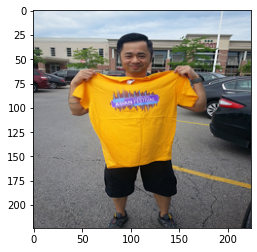

In [56]:
plt.imshow(myimage1)
myimage1 = np.expand_dims(myimage1, axis=0)
myimage1.shape

In [65]:
myprediction = model.predict_on_batch(myimage3)

In [66]:
myprediction.shape
myprediction

array([[2.8093098e-05, 2.1520935e-05, 2.1921657e-03, 2.5745803e-06,
        1.2266997e-05, 2.7944130e-05, 1.9152612e-04, 9.4164634e-06,
        7.4216910e-02, 4.0233634e-05, 1.6967369e-04, 1.0519943e-03,
        8.6004395e-05, 3.0993044e-05, 6.1935891e-05, 5.7426310e-04,
        4.2033539e-06, 4.2028634e-05, 5.2681012e-04, 4.1874704e-01,
        1.1187962e-02, 2.1204345e-03, 2.6018950e-04, 8.0423005e-04,
        2.4043271e-04, 3.0245449e-02, 2.0042709e-04, 1.8375016e-05,
        1.0168506e-02, 4.3317345e-01, 2.7698232e-03, 2.0421739e-03,
        4.0097826e-04, 7.3987008e-03, 2.6270864e-05, 3.1907522e-04,
        5.8601570e-04]], dtype=float32)

In [67]:
np.argmax(myprediction)

29

In [68]:
prediction = np.argmax(myprediction)
encoder.inverse_transform([int(prediction)])

array(['white_dress'], dtype='<U13')